## **1.Importación de librerias y datos**
En este caso usaremos los datos limpios del precio nacional de cacao.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
# Cargar el archivo Excel
df = pd.read_excel("DatosAgroNet_limpio.xlsx")
df_total = df.copy()

train_size = int(len(df_total) * 0.8)
test_size = len(df_total) - train_size
df = df.iloc[:train_size]


# Mostrar las primeras filas
print(df.head())

       Fecha   COP/kg
0 2024-01-01  14271.7
1 2024-01-08  14223.3
2 2024-01-15  14086.3
3 2024-01-22  14329.2
4 2024-01-29  14530.8


### Transformación Box-Cox

In [3]:
from scipy.stats import boxcox

# Supón que df es tu DataFrame con la columna 'COP/kg' positiva
serie = df['COP/kg'].values

# Aplicar Box-Cox, que devuelve la serie transformada y el lambda óptimo
serie_bc, fitted_lambda = boxcox(serie)

# Guardar la serie transformada en el DataFrame
df['COP/kg_boxcox'] = serie_bc

print("Lambda óptimo para Box-Cox:", fitted_lambda)

Lambda óptimo para Box-Cox: 2.9434690557997727


## **3. Definir los parámetros**
`(p,d,q)` → parte no estacional

p: rezagos autorregresivos (cuántos valores pasados usa).  
d: diferencias necesarias para estacionarizar la serie.  
q: rezagos de errores pasados (parte MA).

`(P,D,Q,s)` → parte estacional

P: rezagos autorregresivos estacionales.  
D: diferencias estacionales necesarias (ej. 1 si la serie tiene ciclos anuales).  
Q: rezagos de errores pasados estacionales.  
s: longitud del ciclo → en datos semanales es 52 (1 año ≈ 52 semanas).

In [4]:
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX

warnings.filterwarnings("ignore")

mejor_mse = float("inf")
mejores_parametros = None
mejor_modelo = None

p = d = q = range(0, 3)  # prueba valores de 0 a 2
P = D = Q = range(0, 2)  # valores típicos más bajos para estacionalidad
#s = 52  # periodicidad estacional semanal anual

for s in [4, 12, 26, 52]: 
    for i in p:
        for j in d:
            for k in q:
                for I in P:
                    for J in D:
                        for K in Q:
                            try:
                                modelo = SARIMAX(df['COP/kg'],
                                                order=(i,j,k),
                                                seasonal_order=(I,J,K,s),
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                                resultado = modelo.fit(disp=False)

                                # Pronóstico
                                forecast = resultado.get_forecast(steps=test_size)
                                pred_mean = forecast.predicted_mean
                                mse = mean_squared_error(df_total['COP/kg'].iloc[-test_size:], pred_mean)

                                if mse < mejor_mse:
                                    mejor_mse = mse
                                    mejores_parametros = ((i,j,k), (I,J,K,s))
                                    mejor_modelo = resultado
                            except:
                                continue

if mejores_parametros is not None:
    print(f'Mejor modelo SARIMA: orden no estacional {mejores_parametros[0]}, orden estacional {mejores_parametros[1]}, MSE: {mejor_mse}')
else:
    print("No se encontró ningún modelo SARIMA válido.")


Mejor modelo SARIMA: orden no estacional (2, 1, 2), orden estacional (0, 0, 1, 52), MSE: 4794109.039603894


## **4. Aplicar el modelo a los datos**

In [19]:
# Ajustar el modelo SARIMA (p,d,q) ( P,D,Q,s)
modelo = SARIMAX(df['COP/kg'], 
                 order=(2,1,2), 
                 seasonal_order=(1,0,1,52),
                 enforce_stationarity=False, 
                 enforce_invertibility=False)

resultado = modelo.fit()

print(resultado.summary())

                                      SARIMAX Results                                       
Dep. Variable:                               COP/kg   No. Observations:                   64
Model:             SARIMAX(2, 1, 2)x(1, 0, [1], 52)   Log Likelihood                 -66.397
Date:                              Sun, 19 Oct 2025   AIC                            146.794
Time:                                      20:42:39   BIC                            147.350
Sample:                                           0   HQIC                           143.044
                                               - 64                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5402      2.655      0.203      0.839      -4.663       5.744
ar.L2          0.11

In [20]:
from statsmodels.stats.diagnostic import acorr_ljungbox
lb_test = acorr_ljungbox(residuos, lags=[10], return_df=True)
print(lb_test)

from scipy.stats import shapiro
print(shapiro(residuos))

     lb_stat  lb_pvalue
10  6.423247   0.778539
ShapiroResult(statistic=np.float64(0.834407903157476), pvalue=np.float64(5.690216244848887e-07))


1. Prueba de autocorrelación (Ljung-Box, ACF/PACF):  
Se usa para detectar dependencia temporal residual no modelada.  
Si p-valor > 0.05: no se rechaza independencia, residuos adecuados.  
Si p-valor ≤ 0.05: hay autocorrelación, revisar parámetros.  

2. Pruebas de normalidad (Shapiro-Wilk, Jarque-Bera):  
Verifica si residuos siguen distribución normal (supuesto común en modelos clásicos).  
Si p-valor > 0.05: no se rechaza normalidad, validando supuestos.  
Si p-valor ≤ 0.05: residuos no normales, considerar transformaciones sobre COP/kg o métodos robustos (modelos no lineales como LSTM o XGBoost).  

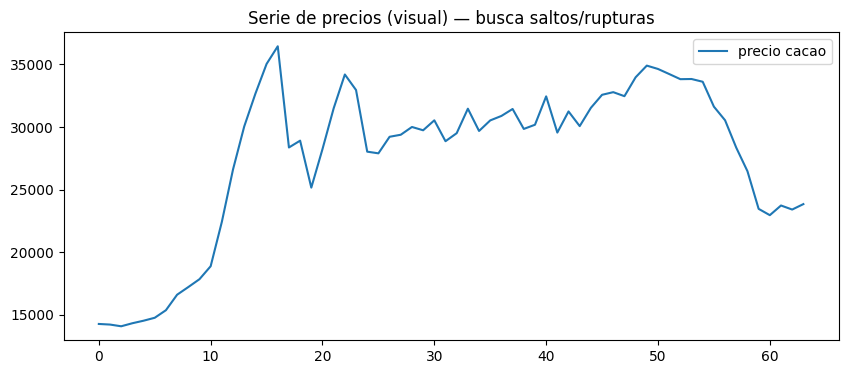

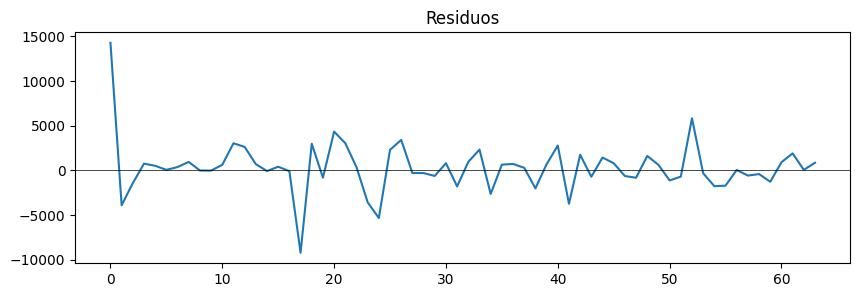

Outliers (indices): [ 0 17]
Número outliers: 2
ARCH test: (np.float64(3.3862934822582336), np.float64(0.9708188687201574), 0.28769009376158383, 0.98054290268016)
Ljung-Box (lags 10,20):
      lb_stat  lb_pvalue
10   6.423247   0.778539
20  12.339921   0.903879


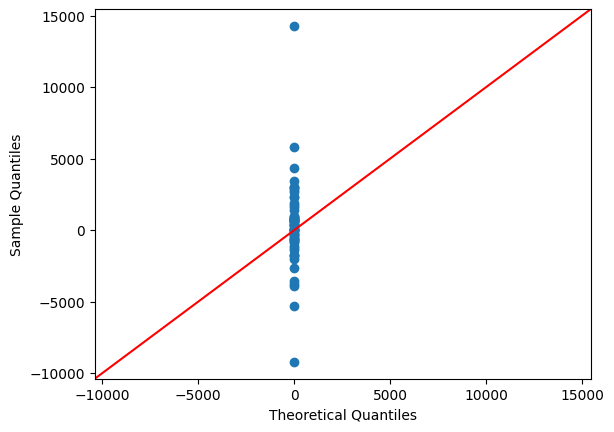

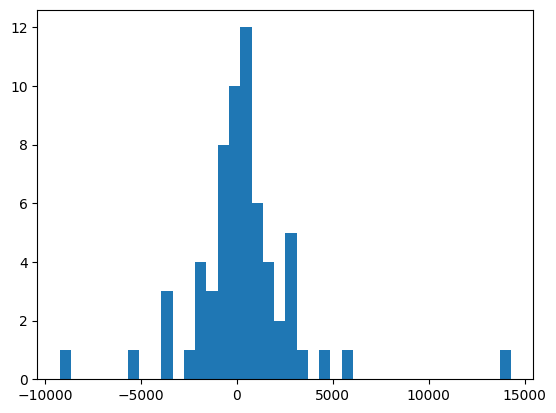

In [14]:
# supuestos: y (pd.Series) es tu serie de precios, res es el resultado SARIMAX (fit) ya estimado
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_arch, acorr_ljungbox
from scipy import stats

# residuos
resid = residuos

# 1.1 - Graficar serie original y marcar período del shock
plt.figure(figsize=(10,4))
plt.plot(df["COP/kg"], label='precio cacao')
# si conoces periodo del aumento, p.ej. fecha_inicio, fecha_fin:
# plt.axvspan('2020-01-01','2021-06-01', color='red', alpha=0.2)
plt.title("Serie de precios (visual) — busca saltos/rupturas")
plt.legend()
plt.show()

# 1.2 - Graficar residuos (ver outliers puntuales)
plt.figure(figsize=(10,3))
plt.plot(resid)
plt.axhline(0, color='k', lw=0.5)
plt.title("Residuos")
plt.show()

# 1.3 - Residuos estandarizados y detección simple de outliers
std_resid = (resid - np.mean(resid)) / np.std(resid)
outliers = np.where(np.abs(std_resid) > 3)[0]
print("Outliers (indices):", outliers)
print("Número outliers:", len(outliers))

# 1.4 - Test de heteroscedasticidad (ARCH)
print("ARCH test:", het_arch(resid))

# 1.5 - Autocorrelación residuos (Ljung-Box)
print("Ljung-Box (lags 10,20):")
print(acorr_ljungbox(resid, lags=[10,20], return_df=True))

# 1.6 - QQ-plot y histograma (comprobar colas)
sm.qqplot(resid, line='45')
plt.show()
plt.hist(resid, bins=40)
plt.show()


In [21]:
# Hacer predicción para el próximo semestre (26 semanas)
prediccion = resultado.get_forecast(steps=test_size)

# Extraer predicción y intervalos de confianza
media_prediccion = prediccion.predicted_mean
intervalos_confianza = prediccion.conf_int()

In [22]:
# Calcular métricas de error
mae = mean_absolute_error(df_total['COP/kg'].iloc[-test_size:], media_prediccion)
rmse = np.sqrt(mean_squared_error(df_total['COP/kg'].iloc[-test_size:], media_prediccion))

print(f'MAE: {mae:.4f}')
print(f'RMSE: {rmse:.4f}')

MAE: 3599.2483
RMSE: 4374.1097


## **5. Graficar los resultados del forecast**

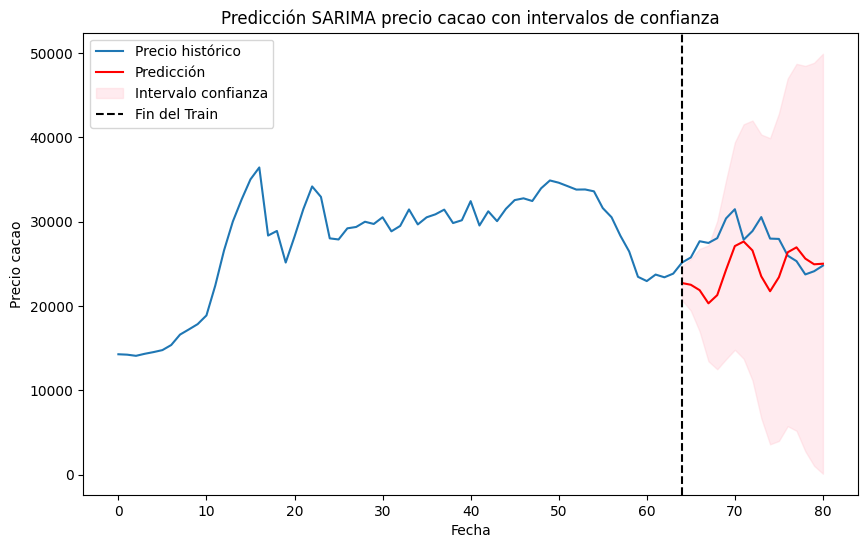

In [23]:
# Graficar datos históricos y predicción con intervalos de confianza
plt.figure(figsize=(10,6))
plt.plot(df_total.index, df_total['COP/kg'], label='Precio histórico')
plt.plot(media_prediccion.index, media_prediccion, color='red', label='Predicción')
plt.fill_between(intervalos_confianza.index, 
                 intervalos_confianza.iloc[:, 0], 
                 intervalos_confianza.iloc[:, 1], color='pink', alpha=0.3, label='Intervalo confianza')
plt.axvline(df_total.index[train_size], color='k', linestyle='--', label='Fin del Train')

plt.xlabel('Fecha')
plt.ylabel('Precio cacao')
plt.title('Predicción SARIMA precio cacao con intervalos de confianza')
plt.legend()
plt.show()

El modelo logró capturar el alza de precios y refleja un posible escenario de continuidad de la tendencia alsista. Los intervalos de confianza amplios sugieren que el cacao es **altamente volátil**, y que el pronóstico sirve más como rango de posibles escenarios que como cifra exacta.